In [1]:
from src import *
from src.EAFSC import *
import matplotlib.pyplot as plt 
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score,silhouette_score,davies_bouldin_score
import pickle
import cv2
from torchvision import transforms
from transformers import AutoImageProcessor, AutoModel
from torch_geometric.explain import Explainer, GNNExplainer

/d/hanr/anaconda3/envs/EMSC/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--dataset", default='BRCA_phk', help="The name of dataset.")
parser.add_argument("--checkpoint", default=1, help="1 represents using the trained model.")
parser.add_argument("--k", default=50, help="The number of neighbors. Default is 50")
parser.add_argument("--pca_dim", default=200, help="The dim of pca. Default is 1000")
parser.add_argument("--clus_num", default=20, help="The number of clusters.")

parser.add_argument("--threshold", default=550, help="The threshold of neighbors. Default is 500")
parser.add_argument("--topk", type=int, default=10, help="The number of neighbors to search")
parser.add_argument("--num_centroids", type=int, default=50, help="The number of centroids for K-means Clustering")
parser.add_argument("--num_kmeans", type=int, default=5, help="The number of K-means Clustering for being robust to randomness")
parser.add_argument("--device", type=int, default=1)

parser.add_argument("--layers", nargs='?', default='[128]', help="The number of units of each layer of the GNN. Default is [256]")
parser.add_argument("--pred_hid", type=int, default=256, help="The number of hidden units of layer of the predictor. Default is 512")
parser.add_argument("--clus_num_iters", type=int, default=20)
parser.add_argument("--eval_freq", type=float, default=5, help="The frequency of model evaluation")
parser.add_argument("--mad", type=float, default=0.999, help="Moving Average Decay for Teacher Network")
parser.add_argument("--lr", type=float, default=0.001, help="learning rate")    
parser.add_argument("--es", type=int, default=3000, help="Early Stopping Criterion")
parser.add_argument("--epochs", type=int, default=500)
parser.add_argument("--batch_size", type=int, default=100)
parser.add_argument("--n_heads", type=int, default=4)
parser.add_argument("--dropout", type=float, default=0.0)
args, _=parser.parse_known_args()

In [3]:
# chage to your own path.
adata_path = './10X_Human_Breast_Cancer' # This is the path where the file is located.
adata_name = 'filtered_feature_bc_matrix.h5' # This is the name of the h5 file.
label_path = './10X_Human_Breast_Cancer/metadata.tsv' # This is the path where the label is located.
image_path = './10X_Human_Breast_Cancer/spatial/full_image.tif'
label_name = "ground_truth" # This is the column name where the label is.
save_feat = './results/feat/'+args.dataset+'.npy'
save_feat_fuse = './results/feat/'+args.dataset+'_fuse.npy'
save_label = './results/label/'+args.dataset+'.csv'
save_model = './results/model/'+args.dataset+'.pkl'
save_args = './results/args/'+args.dataset+'.json'
save_gnn = './results/gnn/'+args.dataset+'/'

In [4]:
adata = read_adata(adata_path,adata_name)

/d/hanr/anaconda3/envs/EMSC/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


In [5]:

pd_label = pd.read_csv(label_path,sep='\t')
df_label = pd.DataFrame(pd_label,columns=[label_name])
categorical = pd.Categorical(df_label[label_name])
codes = categorical.codes

print("\n数字编码:")
# print(codes)
original_labels = categorical.categories[codes]
print(np.unique(codes))
print("\n方法1 - 使用categories映射:")
print(np.unique(original_labels))
# print(original_labels)
adata.obsm['label']=codes
# print(adata)




数字编码:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

方法1 - 使用categories映射:
['DCIS/LCIS_1' 'DCIS/LCIS_2' 'DCIS/LCIS_4' 'DCIS/LCIS_5' 'Healthy_1'
 'Healthy_2' 'IDC_1' 'IDC_2' 'IDC_3' 'IDC_4' 'IDC_5' 'IDC_6' 'IDC_7'
 'IDC_8' 'Tumor_edge_1' 'Tumor_edge_2' 'Tumor_edge_3' 'Tumor_edge_4'
 'Tumor_edge_5' 'Tumor_edge_6']


In [6]:
node_colors=plt.cm.Set3(np.linspace(0, 1, 20))
print(node_colors)
keys = np.unique(original_labels)
values = node_colors
combined = zip(keys, values)
dictionary = dict(combined)
print(dictionary)

[[0.55294118 0.82745098 0.78039216 1.        ]
 [0.55294118 0.82745098 0.78039216 1.        ]
 [1.         1.         0.70196078 1.        ]
 [1.         1.         0.70196078 1.        ]
 [0.74509804 0.72941176 0.85490196 1.        ]
 [0.98431373 0.50196078 0.44705882 1.        ]
 [0.98431373 0.50196078 0.44705882 1.        ]
 [0.50196078 0.69411765 0.82745098 1.        ]
 [0.99215686 0.70588235 0.38431373 1.        ]
 [0.99215686 0.70588235 0.38431373 1.        ]
 [0.70196078 0.87058824 0.41176471 1.        ]
 [0.70196078 0.87058824 0.41176471 1.        ]
 [0.98823529 0.80392157 0.89803922 1.        ]
 [0.85098039 0.85098039 0.85098039 1.        ]
 [0.85098039 0.85098039 0.85098039 1.        ]
 [0.7372549  0.50196078 0.74117647 1.        ]
 [0.8        0.92156863 0.77254902 1.        ]
 [0.8        0.92156863 0.77254902 1.        ]
 [1.         0.92941176 0.43529412 1.        ]
 [1.         0.92941176 0.43529412 1.        ]]
{'DCIS/LCIS_1': array([0.55294118, 0.82745098, 0.78039216, 

In [7]:
print(adata.obsm['label'])

[18  9  4 ...  9 15 14]


In [8]:
adata = process_adata(adata,args.pca_dim,args.k)
print(adata.obsm["X_pca"])

AnnData object with n_obs × n_vars = 3798 × 22240
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'log1p'
    obsm: 'spatial', 'label', 'X_pca', 'distance', 'adj_k', 'distance_k'
[[-27.14210314  20.79177073   4.76602659 ...   3.27875169  -4.00060345
    1.61022406]
 [ 13.22129414  -6.70295281  21.94169687 ...  -1.01081942  -0.60575016
    1.47099883]
 [-33.73139631   5.15603187  -1.21176808 ...  -0.91789203  -7.19752058
    7.40744522]
 ...
 [ 13.98373815  -6.19003904  22.46735224 ...  -1.64220308   1.15401075
    1.17826961]
 [-13.7794833   21.17308591   5.44185539 ...   0.25695236  -2.93404662
   -0.12048608]
 [  4.30992085 -12.86029795 -18.35854654 ...   0.34205904  -0.17261418
   -0.86848013]]


In [9]:
 img_size=112
 full_img = cv2.imread(image_path)
 # 步骤2: BGR转RGB (可选但推荐)
 full_img = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)
 print(full_img.shape)
 patches = []
 # 步骤3: 使用PyTorch转换管道
 transform = transforms.Compose([
     transforms.ToTensor(),  # 自动: 1. 转Tensor 2. HWC->CHW 3. 归一化到[0,1]
     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 如需标准化
# ])


 for x, y in adata.obsm['spatial']:
     patch=full_img[y-img_size:y+img_size, x-img_size:x+img_size]
     # 执行转换
     tensor_patch = transform(patch)  # 得到 [3, 244, 244] 的FloatTensor
     # print(full_image,full_image.shape)
     print(patch.shape,tensor_patch.shape)
     patches.append(tensor_patch.numpy())
 patches = np.array(patches)
 print(patches.shape)

In [10]:
 processor = AutoImageProcessor.from_pretrained("./phikon-v2")
 model = AutoModel.from_pretrained("./phikon-v2")
 model.eval()
 inputs = {"pixel_values":torch.from_numpy(patches).squeeze(dim=0)}
 with torch.inference_mode():
     outputs = model(**inputs)
     print(outputs.last_hidden_state,outputs.last_hidden_state.shape)
     features = outputs.last_hidden_state[:, 0, :]  # (1, 1024) shape
     print(features,features.shape)
     np.save(f"./results/img_feat_phi/"+args.dataset+".npy", features.numpy())

In [11]:
image_data = np.load("./results/img_feat_phi/"+args.dataset+".npy")
image_data = np.array(image_data)
image_data= torch.Tensor(image_data).cuda(args.device)
print(image_data,image_data.shape,image_data.device)


tensor([[-0.2157,  0.1878, -0.3357,  ...,  0.0540,  0.0092, -0.1218],
        [ 0.0270, -0.5468, -0.3434,  ..., -0.2637, -0.0587, -0.4541],
        [-0.1131, -0.0586, -0.2179,  ..., -0.0510,  0.1878, -0.4608],
        ...,
        [-0.2152,  0.0326, -0.0864,  ...,  0.0068, -0.2219, -0.5596],
        [ 0.1816,  0.0550, -0.4489,  ..., -0.0961, -0.0067,  0.0015],
        [ 0.1484, -0.0841, -0.3266,  ..., -0.2247,  0.1671, -0.1483]],
       device='cuda:1') torch.Size([3798, 1024]) cuda:1


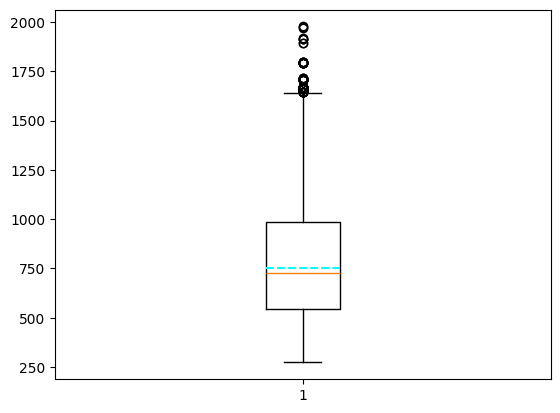

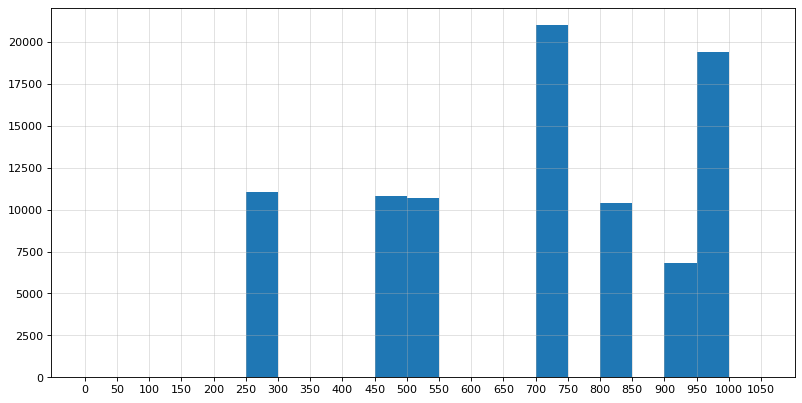

In [12]:
DIS_K=adata.obsm['distance_k']
DIS_K_plot=DIS_K[np.triu_indices(DIS_K.shape[0],k=1)]
DIS_K_plot=DIS_K_plot[DIS_K_plot>0] 
#箱线图
plt.boxplot(DIS_K_plot, showmeans=True, meanline=True,meanprops={'color': 'cyan', 'linewidth': 1.5})
plt.show()
num_bin=[0]
#直方图
i=0
while i<=1000:
    i+=50
    num_bin.append(i)
plt.figure(dpi=80,figsize=(12,6))
plt.hist(DIS_K_plot, num_bin)
plt.xticks(num_bin)
plt.grid(alpha=0.4)
plt.show()

In [13]:
def plot(adata):
    a = np.array(adata.obs["pred"]).astype(int)
    a = np.squeeze(a)
    position = np.ascontiguousarray(adata.obsm["spatial"]) 
    x = np.ascontiguousarray(position[:,0])
    y = np.ascontiguousarray(position[:,1])
    n = len(np.unique(adata.obs["pred"]))
    print(n)
    plt.rcParams['axes.unicode_minus']=False
    ax=plt.scatter(x,y, c=a,cmap='Spectral', s=n) 
    ax.axes.invert_yaxis()
    plt.gca().set_aspect('equal', 'datalim') 
    # plt.colorbar(boundaries=np.arange(n+1)-0.5).set_ticks(np.arange(n))
    
    plt.legend(handles=ax.legend_elements(num=range(n))[0],labels=range(n),ncol=2,loc=2, bbox_to_anchor=(1.01,1.0))

    plt.show()

In [14]:
torch.cuda.empty_cache()

In [16]:
def train(adata,threshold):
        data = prepare_data(adata,threshold)
        model_AFSL =EAFSCcluster()
        #Run
        model_AFSL.train(data,image_data,args,n_clusters=args.clus_num,init_spa=True,res=0.7, tol=5e-3, lr=0.05, max_epochs=args.epochs,nhid=128)
        x,y_pred=model_AFSL.predict()
        refined_pred=refine(adata,sample_id=adata.obs.index.tolist(), pred=y_pred.tolist())
        adata.obs["pred"]=refined_pred
        NMI = normalized_mutual_info_score(adata.obsm["label"], adata.obs["pred"], average_method='arithmetic')
        ARI = adjusted_rand_score(adata.obsm["label"], adata.obs["pred"])
        FMI = fowlkes_mallows_score(adata.obsm["label"], adata.obs["pred"]) 
        SC = silhouette_score(x.cpu().detach().numpy(), adata.obs["pred"])
        DBI = davies_bouldin_score(x.cpu().detach().numpy(), adata.obs["pred"])
        print('===== ARI:{:.3f},NMI:{:.3f},FMI:{:.3f},SC:{:.3f},DBI:{:.3f} ===='.format(ARI,NMI,FMI,SC,DBI))
        plot(adata)
        torch.cuda.empty_cache()

In [17]:
def test(adata,checkpoint_path):
    model_AFSL = EAFSCcluster()
    with open(checkpoint_path,'rb') as file:
        model_AFSL  = pickle.loads(file.read())
    args = load(save_args)

    
    x,y_pred=model_AFSL.predict()
    refined_pred=refine(adata,sample_id=adata.obs.index.tolist(), pred=y_pred.tolist())
    adata.obs["pred"]=refined_pred
    adata.obsm['EMSC']=x.cpu().detach().numpy()
    NMI = normalized_mutual_info_score(adata.obsm["label"], adata.obs["pred"], average_method='arithmetic')
    ARI = adjusted_rand_score(adata.obsm["label"], adata.obs["pred"])
    FMI = fowlkes_mallows_score(adata.obsm["label"], adata.obs["pred"]) 
    SC = silhouette_score(x.cpu().detach().numpy(), adata.obs["pred"])
    DBI = davies_bouldin_score(x.cpu().detach().numpy(), adata.obs["pred"])
    print('===== ARI:{:.3f},NMI:{:.3f},FMI:{:.3f},SC:{:.3f},DBI:{:.3f} ===='.format(ARI,NMI,FMI,SC,DBI))
    return model_AFSL


    

In [18]:
if args.checkpoint == 0:
    train(adata,args.threshold)
else:
    model_AFSL=test(adata,save_model)

参数已从 ./results/args/BRCA_phk.json 加载
Initializing cluster centers with kmeans, n_clusters known
===== ARI:0.667,NMI:0.726,FMI:0.692,SC:0.472,DBI:0.981 ====


In [65]:
with torch.no_grad():
    image_data = model_AFSL.model.CLmodel.image_prdictor(model_AFSL.image_data)
            
    feat_fuse = model_AFSL.model.CLmodel.fusion(torch.tensor(model_AFSL.data.x).float().to(args.device),image_data)
print(model_AFSL.data.x.shape,model_AFSL.image_data.shape,feat_fuse.shape)

(3798, 200) torch.Size([3798, 1024]) torch.Size([3798, 200])


In [66]:
# 获取可视化子图中的节点列表
def get_graph_node_list(explanation, edge_threshold=0.5):
    """
    获取可视化子图中的节点列表
    
    参数:
    explanation: Explanation 对象
    edge_threshold: 边重要性阈值
    
    返回:
    (节点ID列表, 节点重要性字典, 边列表)
    """
    # 获取重要边
    edge_mask = explanation.edge_mask
    edge_index = explanation.edge_index
    
    # 筛选超过阈值的边
    important_edges = edge_index[:, edge_mask > edge_threshold]
    
    # 获取所有涉及的节点
    node_ids = set()
    for i in range(important_edges.shape[1]):
        src = important_edges[0, i].item()
        dst = important_edges[1, i].item()
        node_ids.add(src)
        node_ids.add(dst)
    
    # 添加目标节点（确保包含）
    node_ids.add(explanation.index)
    
    # 转换为排序列表
    node_list = sorted(node_ids)
    
    # 获取节点重要性（平均特征重要性）
    node_importance = {}
    for node_id in node_list:
        # 平均所有特征的重要性
        imp = explanation.node_mask[node_id].mean().item()
        node_importance[node_id] = imp
    
    # 获取边列表 (源节点, 目标节点, 重要性)
    edge_list = []
    for i in range(important_edges.shape[1]):
        src = important_edges[0, i].item()
        dst = important_edges[1, i].item()
        imp = edge_mask[i].item()
        edge_list.append((src, dst, imp))
    
    return node_list, node_importance, edge_list

import numpy as np
from collections import defaultdict
from scipy.spatial.distance import cdist

class NodeFeatureAnalyzer:
    def __init__(self, nodes, features, labels):
        """
        初始化节点特征分析器
        
        参数:
        nodes: 节点ID列表
        features: 节点特征矩阵，形状为 (n_nodes, n_features)
        labels: 节点标签列表
        """
        self.nodes = np.array(nodes)
        self.features = np.array(features)
        self.labels = np.array(labels)
        
        # 验证输入
        if len(nodes) != len(features) or len(nodes) != len(labels):
            raise ValueError("节点、特征和标签的数量必须相同")
        
        # 按标签分组节点
        self.grouped_nodes = defaultdict(list)
        self.grouped_features = defaultdict(list)
        
        for node, feature, label in zip(nodes, features, labels):
            self.grouped_nodes[label].append(node)
            self.grouped_features[label].append(feature)
    
    def find_closest_to_mean(self, target_label, distance_metric='euclidean'):
        """
        找到与特定标签下节点特征平均值最接近的节点
        
        参数:
        target_label: 目标标签
        distance_metric: 距离度量方法 ('euclidean', 'cosine', 'cityblock'等)
        
        返回:
        (最接近的节点ID, 该节点的特征, 平均特征, 距离值)
        """
        # 获取目标标签的所有特征
        target_features = self.grouped_features.get(target_label)
        
        if not target_features:
            raise ValueError(f"标签 '{target_label}' 没有对应的节点")
        
        target_features = np.array(target_features)
        
        # 计算平均特征
        mean_feature = np.mean(target_features, axis=0)
        
        # 计算每个节点到平均特征的距离
        distances = cdist(target_features, [mean_feature], metric=distance_metric).flatten()
        
        # 找到最小距离的索引
        min_idx = np.argmin(distances)
        
        # 获取对应的节点ID
        closest_node = self.grouped_nodes[target_label][min_idx]
        closest_feature = target_features[min_idx]
        
        return closest_node, closest_feature, mean_feature, distances[min_idx]


In [84]:
# 示例数据
nodes = adata.obs['in_tissue'].index

# 特征矩阵 (10个节点, 每个节点3个特征)
features = adata.obsm['EMSC']

# 节点标签
labels = adata.obsm["label"]

# 创建分析器
analyzer = NodeFeatureAnalyzer(nodes, features, labels)
# 分析标签'A'
target_label = 0
try:
    closest_node, closest_feature, mean_feature, min_distance = analyzer.find_closest_to_mean(target_label)
    
    print(f"标签 '{target_label}' 的节点: {analyzer.grouped_nodes[target_label]}")
    print(f"最接近平均特征的节点: {closest_node}")
    print(f"与平均特征的距离: {min_distance:.4f}")


except ValueError as e:
    print(e)


# print(adata.obs['in_tissue'])
df=adata.obs['in_tissue']
position = df.index.get_loc(closest_node)
# position=1189
print(position)


标签 '0' 的节点: ['AAATAGCTTAGACTTT-1', 'AAATTCCAGGTCCAAA-1', 'AACCTGTCACGGAATT-1', 'AAGGATCGATCGCTTG-1', 'AAGTCAATTGTCGTCA-1', 'AAGTGCCTTGACTGTA-1', 'AATCGCGCAGAGGACT-1', 'ACACCTTACTACTTGC-1', 'ACATCCTGGTAACTGT-1', 'ACATGGCGCCAAAGTA-1', 'ACCACCAATGTAACAA-1', 'ACCCGGATGACGCATC-1', 'ACCGCGGTGGAAGTCG-1', 'ACCTACAGTATGTGGT-1', 'ACCTCCGTTATTCACC-1', 'ACGATCATCTTGTAAA-1', 'ACGTATTACTCCGATC-1', 'ACGTTCGCAATCAATT-1', 'ACTATCCAGGGCATGG-1', 'ACTGCGGACACACCGT-1', 'ACTTTACCCTCATGAA-1', 'AGATGATGGAGTCTGG-1', 'AGCTCTTCGTAACCTT-1', 'AGGGACCGGCTGCGTT-1', 'AGGTATAATTGATAGT-1', 'AGTCCATTGGCTGATG-1', 'AGTCGGTTGCGTGAGA-1', 'AGTGAACAAACTTCTC-1', 'ATAAGTAGGGCGACTC-1', 'ATAGTTCCACCCACTC-1', 'ATATCAACCTACAGAG-1', 'ATATCGGTAGGGAGAT-1', 'ATCGCCAGTCAACATT-1', 'ATGGAACCTTTGCACA-1', 'ATGTAAGGCTGCTCTT-1', 'ATTATAGCTACTTTAC-1', 'ATTCGTGCTATCTCTT-1', 'ATTGTACAACTCGGCT-1', 'CAAGGTCCTATAGGCT-1', 'CAATGTGCCAACCCTT-1', 'CACATTTCTTGTCAGA-1', 'CACCCAAATCTTATGT-1', 'CACCTTGGCGCCTTTG-1', 'CACGCGGAACTGTTGC-1', 'CATACTTAGGCAATAC-1

In [85]:
model = model_AFSL.model.CLmodel.student_encoder
data = model_AFSL.data

explainer = Explainer(
model=model,
algorithm=GNNExplainer(epochs=200),
explanation_type='model',
node_mask_type='attributes',
edge_mask_type='object',
model_config=dict(
    mode='multiclass_classification',
    task_level='node',
    return_type='log_probs',
    ),
)



node_index = position
explanation = explainer(feat_fuse, data.edge_index,index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

# 使用示例
node_list, node_importance, edge_list = get_graph_node_list(explanation, edge_threshold=0.2)

print("\n子图节点列表:")
print(node_list)

explanation.visualize_graph(save_gnn+str(position)+'_Subgraph.png',node_labels=adata.obsm['label'])
print(f"Subgraph visualization plot has been saved to '{save_gnn+str(position)+'_Subgraph.png'}'")

Generated explanations in ['node_mask', 'edge_mask']

子图节点列表:
[90, 957, 1189, 1355, 1810, 2435, 2496, tensor([2496]), 2567, 3067, 3157, 3313, 3342, 3417, 3768, 3775]
图形已保存至: ./results/gnn/BRCA_phk/2496_Subgraph.png
Subgraph visualization plot has been saved to './results/gnn/BRCA_phk/2496_Subgraph.png'


In [86]:
for i in node_list:
  if 'tensor' in str(i):
    continue
  print(i,adata.obs['in_tissue'].index[i],adata.obsm['label'][i],adata.obs['pred'][i],categorical.categories[adata.obsm['label'][i]])

90 AACCTGTCACGGAATT-1 0 13 DCIS/LCIS_1
957 CAACACATCTCCTGCC-1 16 7 Tumor_edge_3
1189 CATTCCCATTCCGTCG-1 16 7 Tumor_edge_3
1355 CCGTGAGGCATTCATG-1 0 13 DCIS/LCIS_1
1810 CTGCCTCATATGCAAC-1 19 7 Tumor_edge_6
2435 GGCCCGGAGCATGTCT-1 0 13 DCIS/LCIS_1
2496 GGGCGCAGCGTTACTC-1 0 13 DCIS/LCIS_1
2567 GGTTACCCGACACTTT-1 16 7 Tumor_edge_3
3067 TATTGACATTTCTGCC-1 0 13 DCIS/LCIS_1
3157 TCCCGCCTATGTGCGT-1 16 7 Tumor_edge_3
3313 TCTGATCGGGTGCTAG-1 0 13 DCIS/LCIS_1
3342 TCTTTAGCAGGCGAAC-1 0 13 DCIS/LCIS_1
3417 TGCCGAAAGCGTATTC-1 0 13 DCIS/LCIS_1
3768 TTGGCGATCCGAATAT-1 0 13 DCIS/LCIS_1
3775 TTGGTATGGCTTGTGT-1 0 7 DCIS/LCIS_1


In [88]:
explanation.visualize_feature_importance(save_gnn+str(position)+'_Feature.png', top_k=10)
print(f"Feature importance plot has been saved to '{save_gnn+str(position)+'_Subgraph.png'}'")

Feature importance plot has been saved to './results/gnn/BRCA_phk/2496_Subgraph.png'


In [100]:
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
def find_most_correlated_column(A, B, target_col_B, method='pearson'):
    """
    找出矩阵 A 中与 B 的指定列最相关的列
    
    参数:
    A (np.ndarray): 特征矩阵 A, 形状 (n_samples, n_features_A)
    B (np.ndarray): 特征矩阵 B, 形状 (n_samples, n_features_B)
    target_col_B (int): B 矩阵中要分析的列索引
    method (str): 相关计算方法 ('pearson', 'spearman')
    plot (bool): 是否绘制相关关系图
    
    返回:
    (最相关列索引, 相关系数, 所有列的相关系数数组)
    """
    # 验证输入
    if A.shape[0] != B.shape[0]:
        raise ValueError("A 和 B 必须有相同的样本数")
    
    if target_col_B < 0 or target_col_B >= B.shape[1]:
        raise ValueError(f"target_col_B 必须在 0 到 {B.shape[1]-1} 范围内")
    
    # 提取目标列
    b_target = B[:, target_col_B]
    
    # 计算所有列的相关系数
    correlations = []
    for col_idx in range(A.shape[1]):
        a_col = A[:, col_idx]
        
        # 选择相关计算方法
        if method == 'pearson':
            corr, _ = pearsonr(a_col, b_target)
        elif method == 'spearman':
            corr, _ = spearmanr(a_col, b_target)
        else:
            raise ValueError("method 必须是 'pearson' 或 'spearman'")
            
        correlations.append(corr)
    
    correlations = np.array(correlations)
    
    # 找到最相关的列
    if method == 'pearson':
        # 皮尔逊相关：绝对值最大的
        abs_correlations = np.abs(correlations)
        sorted_indices = np.argsort(abs_correlations)[::-1]
        top_n_indices = sorted_indices[:5]
        # print(top_n_indices)
        most_correlated_idx = np.argmax(abs_correlations)
    else:
        # 斯皮尔曼相关：直接找最大的（因为秩相关方向有意义）
        sorted_indices = np.argsort(correlations)[::-1]
        top_n_indices = sorted_indices[:5]
        # print(top_n_indices)
        most_correlated_idx = np.argmax(correlations)
    
    max_corr = correlations[most_correlated_idx]
    
    
    
    return most_correlated_idx, max_corr, correlations, top_n_indices

# 创建特征矩阵 A
A = adata.X

# 创建特征矩阵 B，使其部分列与 A 的列相关
B = feat_fuse.cpu()

In [117]:
np.random.seed(42)
target_col = [173,11,185,129]

for target_col_B in target_col:
    most_correlated_idx, max_corr, correlations, top_n_indices = find_most_correlated_column(
        A, B, target_col_B, method='pearson'
    )
    
    for i in top_n_indices:
      print(adata.var['gene_ids'].index[i])

    break
print

MGP
S100G
S100A6
ZNF350-AS1
CRIP1


<function print>

-0.5855950059125119
-0.4163857069710622
-0.3542823068997362
-0.34794329518464134
0.3377470203376012


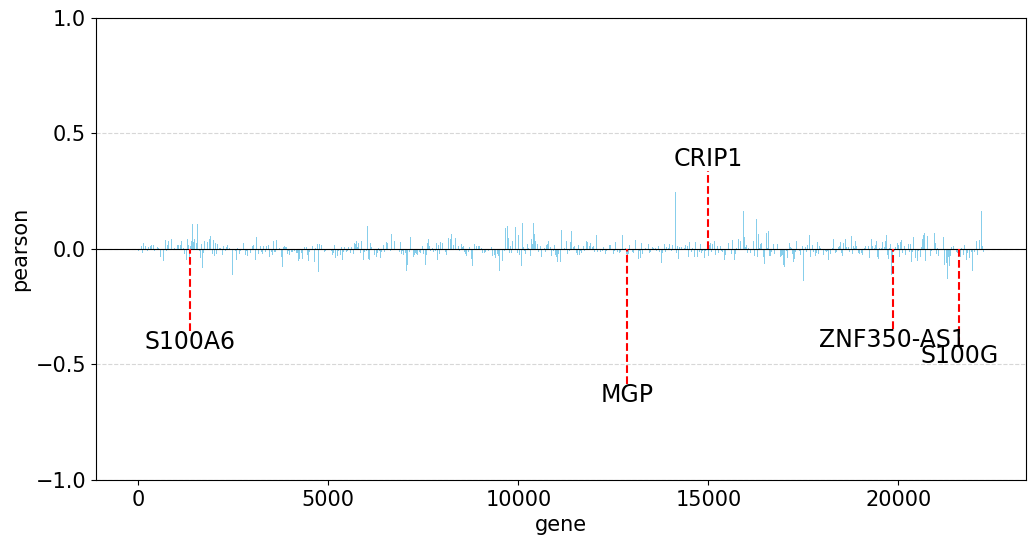

In [138]:

plt.figure(figsize=(12, 6))

# 1. 所有列的相关系数分布
# plt.subplot(1, 2, 1)
plt.bar(range(len(correlations)), correlations, color='skyblue')
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y', linestyle='--',alpha = 0.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("gene",fontsize=15)
plt.ylabel("pearson",fontsize=15)
plt.ylim(-1,1)
# 标记最相关的列
for i in top_n_indices:
    print(correlations[i])
    if correlations[i]>0:
      plt.axvline(x=i, color='red', linestyle='--', ymin=0.5, ymax=correlations[i]/2+0.5)
      plt.text(i,correlations[i],
          adata.var['gene_ids'].index[i],
          ha='center', 
          va='bottom',
          fontsize=17
          )
    else:
      plt.axvline(x=i, color='red', linestyle='--', ymin=0.5+correlations[i]/2, ymax=0.5)
      plt.text(i,correlations[i]-0.1,
          adata.var['gene_ids'].index[i],
          ha='center', 
          va='bottom',
          fontsize=17
          )
    g_i=adata.var['gene_ids'].index[i]
    # plt.text(i, max_corr/2, f' {g_i}\n: {max_corr:.2f}', 
    #         ha='center', va='center', color='red',fontsize=10)

# 2. 最相关列的散点图
# plt.subplot(1, 2, 2)
# sns.regplot(x=A[:, most_correlated_idx], y=b_target, 
#             scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})

# plt.tight_layout()
# plt.savefig(f'correlation_B{target_col_B}_A{most_correlated_idx}.png')
plt.show()

In [ ]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

def plot_gene_zscore_heatmap(adata, gene_list, cluster_key='leiden', 
                             method='average', metric='euclidean',
                             cmap='viridis', figsize=(12, 8), save_path=None):
    """
    绘制基因表达Z-score热力图
    
    参数:
    adata: AnnData对象 (包含原始计数和聚类信息)
    gene_list: 要可视化的基因列表
    cluster_key: 聚类结果在adata.obs中的列名
    method: 层次聚类方法 ('average', 'ward', 'complete'等)
    metric: 距离度量 ('euclidean', 'correlation'等)
    cmap: 颜色映射
    figsize: 图像尺寸
    save_path: 保存路径 (可选)
    """
    # 数据准备
    sc.pp.filter_genes(adata, min_cells=10)  # 过滤低表达基因
    adata_sub = adata[:, gene_list].copy()   # 提取目标基因
    
    # 计算Z-score标准化
    scaler = StandardScaler()
    z_scores = scaler.fit_transform(adata_sub.X.toarray() if scipy.sparse.issparse(adata_sub.X) else adata_sub.X)
    
    # 创建DataFrame
    df = pd.DataFrame(z_scores, 
                     index=adata_sub.obs_names, 
                     columns=gene_list)
    
    # 添加聚类信息
    df['cluster'] = adata_sub.obs[cluster_key].astype('category')
    
    # 按聚类分组求均值
    cluster_means = df.groupby('cluster').mean()
    
    # 层次聚类
    row_linkage = scipy.cluster.hierarchy.linkage(
        cluster_means, method=method, metric=metric
    )
    col_linkage = scipy.cluster.hierarchy.linkage(
        cluster_means.T, method=method, metric=metric
    )
    
    # 创建聚类热力图
    plt.figure(figsize=figsize)
    sns.set(font_scale=1.2)
    
    # 使用seaborn的clustermap
    g = sns.clustermap(
        cluster_means,
        row_linkage=row_linkage,
        col_linkage=col_linkage,
        cmap=cmap,
        center=0,  # Z-score中心为0
        robust=True,  # 防止异常值影响颜色范围
        dendrogram_ratio=0.2,  # 树状图比例
        cbar_kws={'label': 'Z-score'},
        figsize=figsize
    )
    
    # 美化标签
    g.ax_heatmap.set_ylabel('Clusters')
    g.ax_heatmap.set_xlabel('Genes')
    g.ax_heatmap.set_title('Gene Expression Z-scores by Cluster')
    
    # 旋转基因标签
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
    
    # 添加网格线
    g.ax_heatmap.hlines(np.arange(1, len(cluster_means)), *g.ax_heatmap.get_xlim(), 
                       colors='gray', linewidth=0.1, alpha=0.5)
    
    # 保存图像
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Saved to {save_path}")
    
    plt.show()
    return g

# 使用示例 --------------------------------------------------
# 加载乳腺癌数据 (示例)
adata = sc.datasets.visium_sge(sample_id="V1_Breast_Cancer_Block_A_Section_1")

# 预处理
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 选择乳腺癌相关基因
breast_cancer_genes = ['ESR1', 'PGR', 'ERBB2', 'KRT5', 'KRT17', 'EGFR', 
                      'FOXA1', 'GATA3', 'MKI67', 'VEGFA', 'CD274']

# 绘制热力图
plot_gene_zscore_heatmap(
    adata, 
    gene_list=breast_cancer_genes,
    cluster_key='cluster',  # 替换为实际聚类列名
    cmap='coolwarm',        # 蓝-白-红色调
    figsize=(14, 8),
    save_path='breast_cancer_gene_zscore_heatmap.png'
)

20


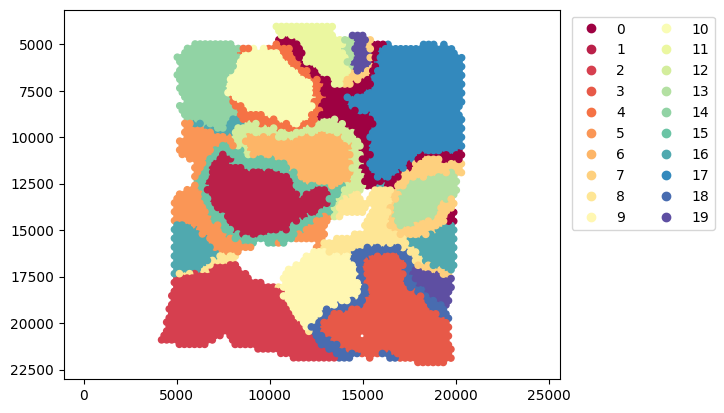

In [ ]:
plot(adata)

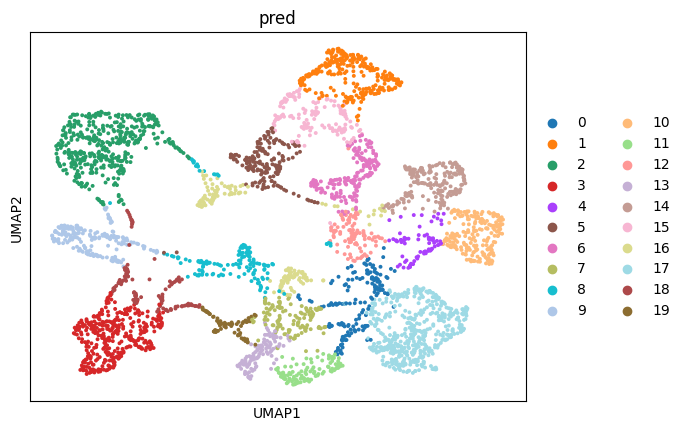

In [ ]:
adata.obs['pred'] = adata.obs['pred'].astype('category')
sc.pp.neighbors(adata, n_neighbors=10,use_rep='EMSC')
sc.tl.umap(adata)
sc.pl.umap(adata, color=["pred"])

<Axes: >

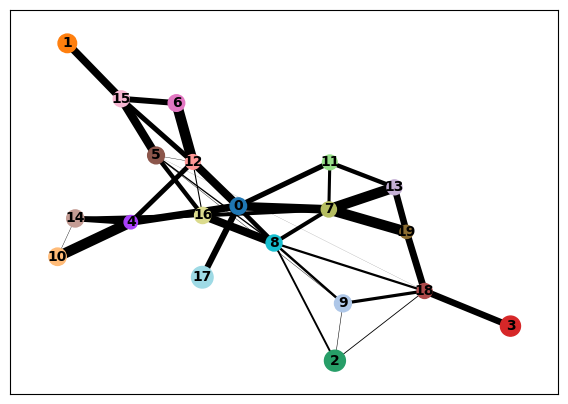

In [ ]:
sc.tl.paga(adata,groups = 'pred')
sc.pl.paga(adata,color = 'pred',show=False)